In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

In [3]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        for vote_index in vote_indices:
            class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
        for elem in where_empty:
            class_probs[elem] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)
        
    return cond_entropy / n_estimators

In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

In [6]:
# num_trials = 10
# n = 3000
# truth = 0.356

# ds = [1, 20, 40]
# kappas = [2, 3, 5, 7.5, 10]

# # Hyperparameter search.
# best_mse = 100000
# best_kappa = 0
# best_exp = 0
# best_var = 0
# for i, kappa in enumerate(kappas):
#     mse = 0
#     for j, d in enumerate(ds):
#         print("Trial %d out of %d in progress." % (len(kappas)*i + j, len(ds)*len(kappas)))
#         trials = np.zeros(num_trials)
#         for t in range(num_trials):
#             X, y = generate_data(n, d)
#             trials[t] = uf(X, y, kappa = kappa)
        
#         exp = np.mean(trials)
#         var = np.var(trials) / num_trials
#         mse += (exp - truth)**2 + var
        
#     if mse < best_mse:
#         best_mse = mse
#         best_kappa = kappa

# print("Best exp: ", best_exp)
# print("Best var: ", best_var)
# print("Best c: ", best_c)
# print("Best lambda: ", best_lambda)

## Compute True Conditional Entropy

In [7]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [8]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [9]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [10]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [11]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left")
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [12]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [13]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return uf(X, y, base = np.exp(1), kappa = 3)
    else:
        raise ValueError("Unrecognized Label!")

In [14]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [15]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 20
n1 = 3000
n2 = 6000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(300, 1201, 90)
sample_sizes_d2 = range(500, 3001, 250)

# Fake params.
# mus = [i * 0.5 for i in range(1, 3)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 2
# num_plotted_trials = 2
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

### Estimated H(Y | X) versus n, d = 1

In [16]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.13813788, 0.17923062, 0.15773763, 0.11188992, 0.13653421,
         0.09560854, 0.15424059, 0.13101785, 0.12443278, 0.12852009,
         0.14889427, 0.13117024, 0.15307133, 0.11717347, 0.14455981,
         0.10829625, 0.12488382, 0.14085038, 0.14620108, 0.16649964],
        [0.13221219, 0.13484286, 0.14468285, 0.14456423, 0.10241296,
         0.14085252, 0.14534728, 0.13858935, 0.12872412, 0.13575775,
         0.13822215, 0.14315023, 0.13607397, 0.12338732, 0.13380865,
         0.13996483, 0.11915956, 0.13127751, 0.1354171 , 0.14567337],
        [0.13128454, 0.11264747, 0.11957414, 0.1399353 , 0.11667448,
         0.1344906 , 0.13889709, 0.13445096, 0.11162097, 0.13259572,
         0.1320547 , 0.14016228, 0.14865953, 0.12158961, 0.12817404,
         0.1359347 , 0.13514547, 0.14352677, 0.11931754, 0.11829825],
        [0.13910563, 0.10337459, 0.11994716, 0.13812858, 0.13745545,
         0.11817568, 0.13505465, 0.1401796 , 0.14537991, 0.12830886,
         0.12052865, 0.13299743

### Estimated H(Y | X) versus mu, d = 1

In [17]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[3.90328701e-01, 3.85050339e-01, 3.91032198e-01, 3.86228018e-01,
         3.72709565e-01, 3.96416769e-01, 3.81805747e-01, 4.31619813e-01,
         4.19073365e-01, 4.07616908e-01, 4.01510107e-01, 3.77523984e-01,
         3.63718661e-01, 3.95433611e-01, 3.80751366e-01, 3.74032970e-01,
         3.75920479e-01, 3.86574234e-01, 3.64515947e-01, 3.64683027e-01],
        [1.42698223e-01, 1.50571628e-01, 1.46294381e-01, 1.44761529e-01,
         1.53755407e-01, 1.45003829e-01, 1.50422058e-01, 1.45904087e-01,
         1.62391317e-01, 1.43862301e-01, 1.40595861e-01, 1.43197337e-01,
         1.47087922e-01, 1.40748166e-01, 1.43290454e-01, 1.53937803e-01,
         1.54525303e-01, 1.52346957e-01, 1.63600506e-01, 1.39377774e-01],
        [5.78232686e-02, 5.30317252e-02, 5.09959702e-02, 5.08675221e-02,
         5.19949245e-02, 5.22255609e-02, 5.08235194e-02, 5.54737202e-02,
         5.64360577e-02, 5.04219012e-02, 5.61363870e-02, 6.08487478e-02,
         4.49972677e-02, 5.02592672e-02, 5.137652

### Estimated H(Y | X) versus n, d = 40

In [18]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.18798922, 0.18734691, 0.16971881, 0.23817794, 0.19219807,
         0.17391251, 0.18296525, 0.16114427, 0.18946031, 0.20374097,
         0.19163898, 0.16069329, 0.19533005, 0.20347593, 0.18034253,
         0.20486625, 0.21155334, 0.19364581, 0.21627204, 0.1899814 ],
        [0.17215346, 0.19043801, 0.19061921, 0.17678348, 0.20103392,
         0.17288179, 0.18651258, 0.18552251, 0.16516208, 0.17336284,
         0.1851095 , 0.16659472, 0.14936939, 0.1773366 , 0.18843432,
         0.16167448, 0.19015327, 0.18570715, 0.18458736, 0.18050814],
        [0.16265912, 0.16223989, 0.15964393, 0.15371528, 0.17522263,
         0.19829896, 0.19136025, 0.19328867, 0.19137012, 0.1673824 ,
         0.17081894, 0.16860206, 0.16716072, 0.15794041, 0.15101747,
         0.15845312, 0.16589896, 0.18035713, 0.17131586, 0.15124835],
        [0.16321886, 0.13473931, 0.17089323, 0.17268369, 0.16321681,
         0.16748581, 0.1563834 , 0.15827527, 0.16391926, 0.15174238,
         0.16343871, 0.17829199

### Estimated H(Y | X) versus mu, d = 40

In [19]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[3.11964234e-01, 3.16430945e-01, 3.18202326e-01, 3.30926705e-01,
         3.19998948e-01, 3.19042867e-01, 3.19020734e-01, 3.19181260e-01,
         3.14672022e-01, 3.19240702e-01, 3.10679700e-01, 3.19476868e-01,
         3.39035535e-01, 3.23615201e-01, 3.13317743e-01, 3.21268726e-01,
         3.19642638e-01, 3.19195739e-01, 3.11409710e-01, 3.20130676e-01],
        [1.39463400e-01, 1.31306848e-01, 1.36270633e-01, 1.35306269e-01,
         1.31051669e-01, 1.40362712e-01, 1.35760696e-01, 1.45463460e-01,
         1.39572912e-01, 1.38460245e-01, 1.38161040e-01, 1.35764855e-01,
         1.33031906e-01, 1.49762253e-01, 1.37145990e-01, 1.36771207e-01,
         1.41534526e-01, 1.40754864e-01, 1.42619136e-01, 1.36304736e-01],
        [4.54201224e-02, 4.36995714e-02, 4.91770748e-02, 4.60158213e-02,
         4.75551995e-02, 4.94997609e-02, 4.85863768e-02, 5.00488563e-02,
         4.97746897e-02, 5.32627273e-02, 4.61768459e-02, 4.67981811e-02,
         4.83538251e-02, 4.76100374e-02, 4.462895

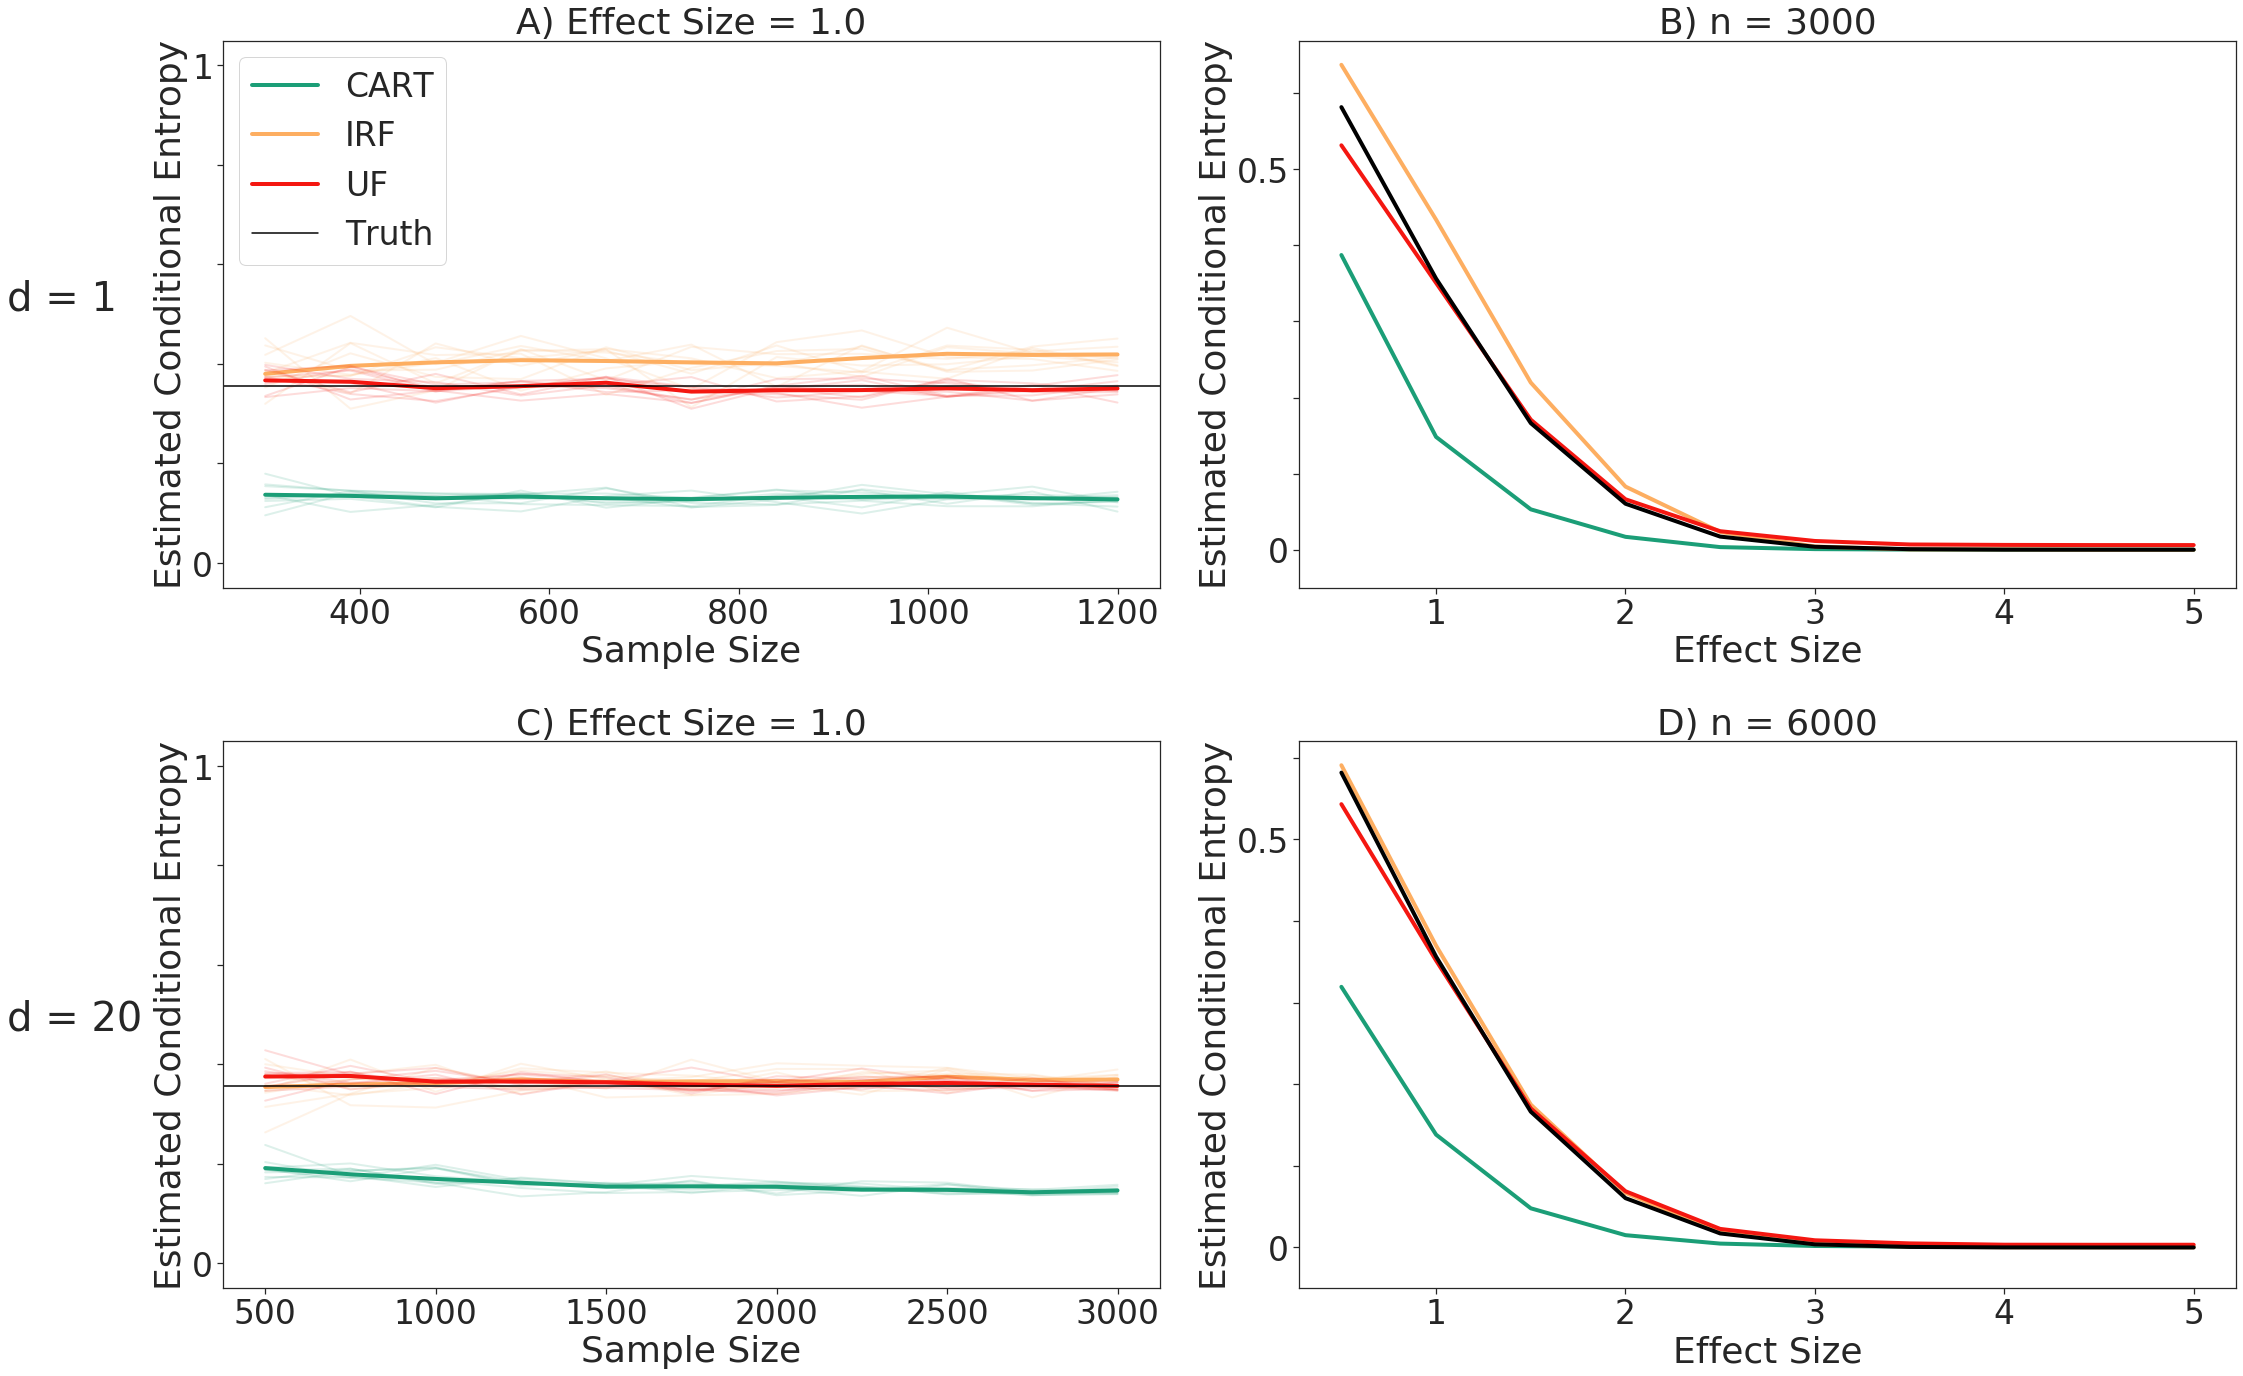

In [20]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)